In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
plt.rcParams["figure.figsize"]=8,8
import math
import numpy as np
import pandas as pd
from scipy import stats
import scipy
import scipy.stats as stat
from scipy.interpolate import make_interp_spline, BSpline
from lmfit.models import Model

### DATA COLLECTION

In [3]:
files = ['trial1.txt','trial2.txt','trial3.txt']
angles_file = 'angles.txt'
data1 = pd.read_csv(files[0], sep="\t")#,) names=['Region Name'])
data2 = pd.read_csv(files[1], sep="\t")
data3 = pd.read_csv(files[2], sep='\t')
angles = pd.read_csv(angles_file)
# data2 = np.loadtxt(file, '\t', dtype = float)
# data = np.delete(data, 1, 1)
# data2 = np.delete(data2, 1, 1)[3000:]
print(f'{len(data1)} data points recorded for {files[0]} with shape {data1.shape}')
print(f'{len(data2)} data points recorded for {files[1]} with shape {data2.shape}')
print(f'{len(data3)} data points recorded for {files[2]} with shape {data3.shape}')
print(f'{len(angles)} data points recorded for {angles_file} with shape {angles.shape}')

#0.000
# 4.650
# 9.052 #start

1801 data points recorded for trial1.txt with shape (1801, 2)
1801 data points recorded for trial2.txt with shape (1801, 2)
1801 data points recorded for trial3.txt with shape (1801, 2)
3 data points recorded for angles.txt with shape (3, 6)


In [4]:
print(angles)

   left_1  center_1  right_1  left_2  center_2  right_2
0 -10.152    -9.052   -7.407  -2.213    -0.672    0.523
1  -2.549    -0.657    0.525 -11.523    -9.620   -7.141
2  -4.848    -2.077    0.142 -11.727   -10.289   -8.959


-0.756+-0.054e^(-0.075x) * cos(1.769*x+1.976)


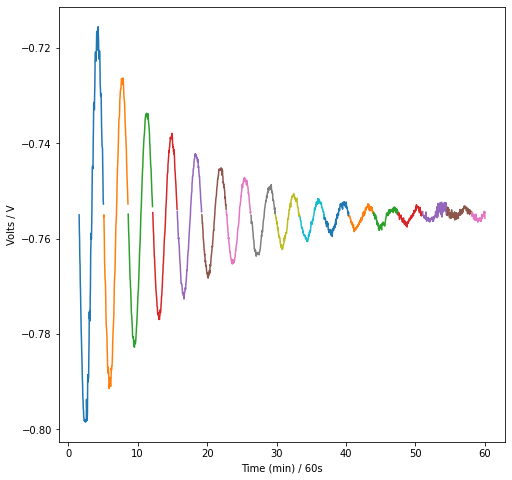

PERIOD FOUND 215.99999999999997 s ± 11.99999999999999 s
r 3625.6666666666665 ± 18.372685039360892
DELTA x 8.379999999999999 ± 1.5895300493472204
THETA 5.778e-04 ± 1.096e-04


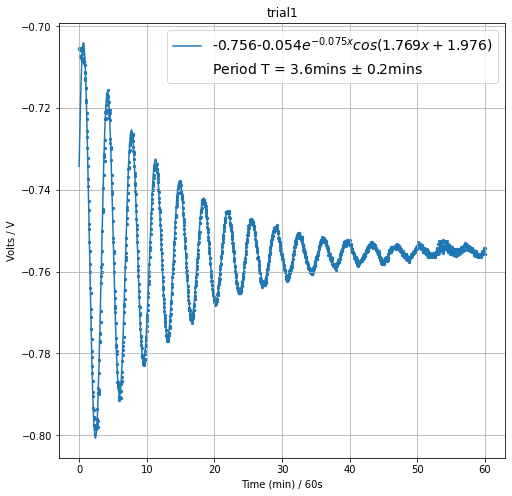

0.046+0.053e^(-0.076x) * cos(1.762*x+0.273)


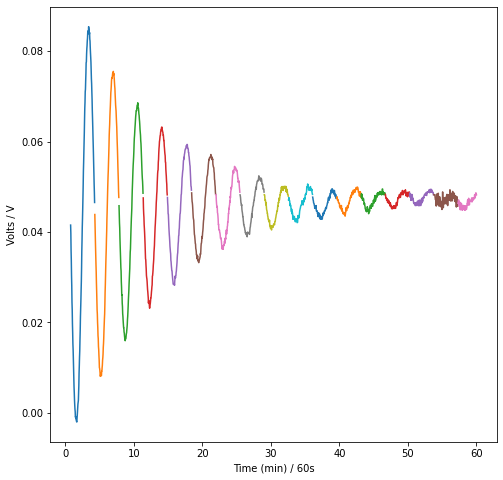

PERIOD FOUND 212.00000000000003 s ± 7.6811457478686105 s
r 3625.6666666666665 ± 18.372685039360892
DELTA x 8.963 ± 2.195830341553939
THETA 6.180e-04 ± 1.514e-04


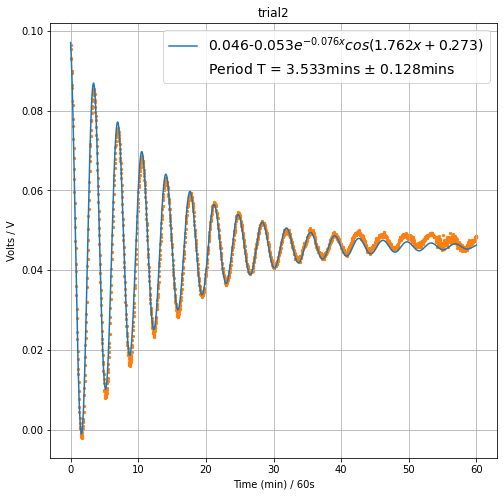

0.113+-0.053e^(-0.075x) * cos(1.762*x+-0.188)


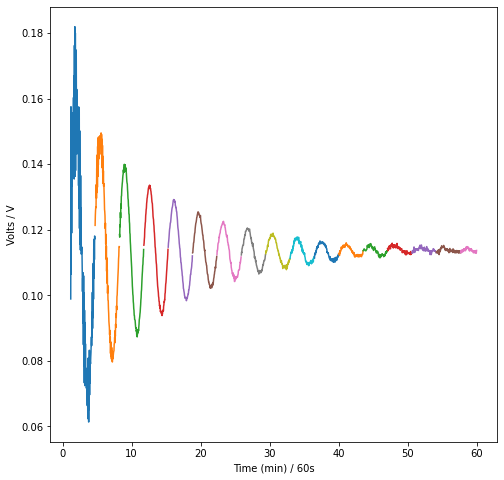

PERIOD FOUND 215.99999999999997 s ± 15.842979517754864 s
r 3625.6666666666665 ± 18.372685039360892
DELTA x 8.212 ± 2.3333588093847317
THETA 5.662e-04 ± 1.609e-04


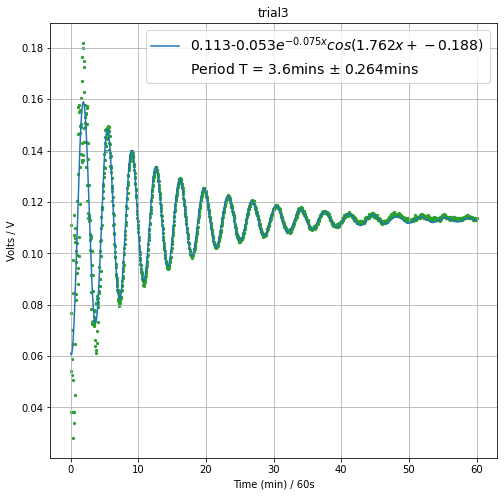

In [31]:
def cavendish(data, angle, c, start, out):
#   print(data[data.index > 50].head())
    #///////////////////////////
    #DATA PREPROCESSING       //
    #///////////////////////////
    x = data['Time (s)']/60
    y = data['Potential (mV)']/1000
    #///////////////////////////
    #FUNCTION MODELING        //
    #///////////////////////////
#     func2 = lambda t,m,theta,A,b,omega_1,delta: m*t+theta+A*np.exp(-t*b)*np.cos(omega_1*t+delta)
#     eqtest, covariance_test = scipy.optimize.curve_fit(func2, x, y, p0=None,absolute_sigma=True)
#     y_model_test = eqtest[0]*x+eqtest[1]+eqtest[2]*np.exp(-x*eqtest[3])*np.cos(eqtest[4]*x+eqtest[5])
#     theta_change_model = eqtest[0]*x+eqtest[1]
    func = lambda t,theta,A,b,omega_1,delta: theta+A*np.exp(-b*t)*np.cos((omega_1*t)+delta)
    eq, covariance = scipy.optimize.curve_fit(func, x, y, p0=None,absolute_sigma=True)
    covDiag = np.diag(covariance) # (pred_theta, pred_A, pred ....), covariance
    y_model = eq[0]+eq[1]*np.exp(-x*eq[2])*np.cos(eq[3]*x+eq[4])
    def y_func(theta,x):
        return theta+eq[1]*np.exp(-x*eq[2])*np.cos(eq[3]*x+eq[4])
    print(f"{eq[0].round(3)}+{eq[1].round(3)}e^(-{eq[2].round(3)}x) * cos({eq[3].round(3)}*x+{eq[4].round(3)})")
    eqlabel = str(eq[0].round(3))+"-"+str(abs(eq[1].round(3)))+"$e^{-"+str(eq[2].round(3))+"x} cos("+str(eq[3].round(3))+"x+"+str(eq[4].round(3))+")$"
    #///////////////////////////
    #DATA AND ERROR CALC      //
    #///////////////////////////
    # omega_o = √(omega_1^2 - b^2)
    omega_1 = eq[3]
    b = eq[2]
#     Error
    sigma_omega_1 = np.sqrt(covDiag[3])
    sigma_b = np.sqrt(covDiag[2])
    omega_o = np.sqrt(omega_1**2 - b**2)
    sigma_omega_o = np.sqrt((omega_1*sigma_omega_1**2/omega_o) + (b*sigma_b**2/omega_o))
#     2π *ø_omega1 / omega1^2
    sigma_period = 2*np.pi*sigma_omega_1 / omega_1**2
#     2π / omega_1
    period = 2*np.pi/omega_1
    
    #////////////////////////////
    # PERIOD CALC ATTEMPT 2    //
    # ///////////////////////////
    
    # calculating period with for-loop fun
    regionmin = start
    regionlength = 106
    # \\\\\\\\\\
    regionmax = regionmin+regionlength
    regionsexamined = 0
    desiredregions = 10
    periods_list = np.array([])
#   PLOTTING TO SEE PERIODS
    fig0, ax0 = plt.subplots()
    ax0.set_ylabel('Volts / V')
    ax0.set_xlabel('Time (min) / 60s')
    for i in range(len(y) % regionlength):
        ax0.plot(x[regionmin:regionmax], y[regionmin:regionmax])
        regionmin += regionlength
        regionmax += regionlength
    plt.show()
    fig0.savefig('ranges_'+out+'.png', bbox_inches='tight')
    regionmin = start
    regionmax = regionmin+regionlength
    for i in range(len(y)):
        if regionmax > (53 * desiredregions):
            break
        min1 = np.argmin(y[regionmin:regionmax])
        max1 = np.argmax(y[regionmin:regionmax])
        period = 2 * np.absolute(x[min1]-x[max1])
        periods_list = np.append(periods_list, period)
        regionmin += regionlength
        regionmax += regionlength
        regionsexamined += 1
#     period = 1/regionsexamined1*np.sum(periods1)
    sigma_period = np.std(periods_list)
#     period = np.mean(period_list)
    print("PERIOD FOUND", period*60, "s ±", sigma_period*60,"s")
#     print(angle)
    sigma_1 = np.std(angle[0:3])
    sigma_2 = np.std(angle[3:7])
    center_1 = angle['center_1']
    center_2 = angle['center_2']
    r_array = np.array([1555+2000+45,1916+1556+170,1915+1554+166]) 
    r = np.mean(r_array)
    r_sigma = np.std(r_array)
    print("r", r, "±", r_sigma)
    center_sigma = np.sqrt(sigma_1**2 + sigma_2**2)
    # arc length s = theta_D * r
    print("DELTA x",abs(center_2 - center_1), "±", center_sigma)
    theta_D = abs(center_2 - center_1)/(4*r)#*180/np.pi
    sigma_theta_D = np.sqrt((center_sigma/(4*r))**2+(-abs(center_2 - center_1)*r_sigma/(4*r**2))**2)#*180/np.pi
    print("THETA {:.3e}".format(theta_D), "± {:.3e}".format(sigma_theta_D))
#     print("FUNC RETURNS", y_func(theta_D,x))
    #///////////////////////////
    #PLOTTING                 //
    #///////////////////////////
    fig1, ax1 = plt.subplots()
    ax1.plot(x, y_model, label=eqlabel)
    ax1.plot([],[], label=f"Period T = {period.round(3)}mins $\pm$ {sigma_period.round(3)}mins", ls='None')
#     ax1.plot([],[], label=f'$\sigma_b$: {sigma_b.round(3)}'+' $\sigma_{\omega1}$: '+f'{sigma_omega_1.round(3)}rads', ls='None')
#     ax1.plot([],[], label='$\sigma_{\omega_o}$: '+f'{sigma_omega_o.round(3)}rads', ls='None')
    ax1.scatter(x, y, color=c, s=5)
    ax1.set_title(out)
    ax1.set_ylabel('Volts / V')
    ax1.set_xlabel('Time (min) / 60s')
    plt.legend(loc='best', fontsize=14)
    plt.grid(True)
    plt.show()
    fig1.savefig('cavendish_'+out+'.png', bbox_inches='tight')
    return (period, sigma_period, theta_D, sigma_theta_D), eq, covDiag
periods = []
sigma_periods = []
theta_Ds = []
sigma_theta_Ds = []
(period_temp, sigma_temp, theta_D_temp, sigma_theta_D_temp), notused1, notused2 = cavendish(data1, angles.iloc[0], 'C0', 47, 'trial1')
periods.append(period_temp)
sigma_periods.append(sigma_temp)
theta_Ds.append(theta_D_temp)
sigma_theta_Ds.append(sigma_theta_D_temp)
(period_temp, sigma_temp, theta_D_temp, sigma_theta_D_temp), notused1, notused2 = cavendish(data2, angles.iloc[1], 'C1', 23, 'trial2')
periods.append(period_temp)
sigma_periods.append(sigma_temp)
theta_Ds.append(theta_D_temp)
sigma_theta_Ds.append(sigma_theta_D_temp)
(period_temp, sigma_temp, theta_D_temp, sigma_theta_D_temp), notused1, notused2 = cavendish(data3, angles.iloc[2], 'C2', 35, 'trial3')
periods.append(period_temp)
sigma_periods.append(sigma_temp)
theta_Ds.append(theta_D_temp)
sigma_theta_Ds.append(sigma_theta_D_temp)


## CALCULATE $G$

[0.0005778247678587846, 0.0006180242713983635, 0.0005662406913671049]
R 0.0449m
R^2 0.0020m
M 0.9170kg
d 0.0666m
\\\\\\\\
T            215.99999999999997
sigma_T      11.99999999999999
thetaD       0.0005778247678587846
sigma_thetaD 0.00010964171032988281
G is 7.15459e-11 ± 1.57320e-11
\\\\\\\\
T            212.00000000000003
sigma_T      7.6811457478686105
thetaD       0.0006180242713983635
sigma_thetaD 0.0001514411156906679
G is 7.94383e-11 ± 2.02989e-11
\\\\\\\\
T            215.99999999999997
sigma_T      15.842979517754864
thetaD       0.0005662406913671049
sigma_thetaD 0.00016091729221571542
G is 7.01116e-11 ± 2.24226e-11


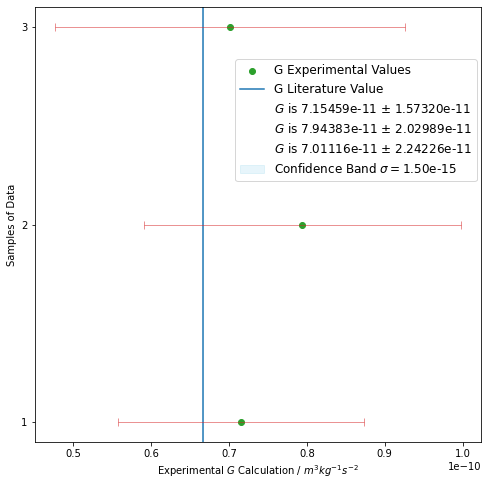

In [22]:
#///////////////////////////
#CONSTANTS                //
#///////////////////////////

# G = (4π^2 * R^2 * d) * theta_d / (T^2 * M)
G_lit = 6.67430e-11 #m3 kg-1 s-2
G_lit_sigma = 0.00015e-11 #m3 kg-1 s-2
R = 44.9/1000 #m
M = 917/1000 #kg
d = 66.56/1000 #m
# print(periods)
# print("±",sigma_periods)
print(theta_Ds)
print("R {:.4f}m".format(R))
print("R^2 {:.4f}m".format(R**2))
print("M {:.4f}kg".format(M))
print("d {:.4f}m".format(d))
periods_seconds = np.array(periods)*60
sigma_periods_seconds = np.array(sigma_periods)*60
# print(periods_seconds)
#///////////////////////////
#ERROR CALCULATION        //
#///////////////////////////
G = np.array([])
G_sigma = np.array([])

for i,(T,theta_D,sigma_T,sigma_theta_D) in enumerate(zip(periods_seconds,theta_Ds,sigma_periods_seconds,sigma_theta_Ds)):
    print("\\\\\\\\\\\\\\\\")
    print("T           ",T)
    print("sigma_T     ",sigma_T)
    print("thetaD      ",theta_D)
    print("sigma_thetaD",sigma_theta_D)
    G = np.append(G, (4*np.pi**2 * R**2 * d * theta_D) / (T**2 * M))
    G_sigma = np.append(G_sigma, (4 * np.pi**2 * d * R**2) / (T**2 * M)* np.sqrt(((2* theta_D * sigma_T / T)**2) + sigma_theta_D**2 ))
    print("G is {:.5e} ± {:.5e}".format(G[i],G_sigma[i]))
#///////////////////////////
#PLOTTING                 //
#///////////////////////////
def fn(x):
    return x
fig2, ax2 = plt.subplots()
ax2.scatter(G, [1,2,3], label="G Experimental Values", color='C2')
ax2.axvline(G_lit, label="G Literature Value")
# ax2.fill_between([1,2,3], G_lit+G_lit_sigma, G_lit-G_lit_sigma, alpha=0.2, color='skyblue', label='Confidence Band')
for exp_value,sigma in zip(G,G_sigma):
    ax2.plot([],[],label="$G$ is {:.5e} ± {:.5e}".format(exp_value,sigma),ls='None')
ax2.plot([],[],label="", ls='None')
ax2.set_xlabel('Experimental $G$ Calculation / $m^3 kg^{-1} s^{-2}$')
ax2.set_ylabel('Samples of Data')
plt.yticks([1,2,3])
ax2.errorbar(G, [1,2,3], xerr=G_sigma, capsize=4, ecolor='C3', elinewidth=0.5, markeredgewidth=0.5,ls='None')
xfill = np.linspace(G_lit-G_lit_sigma, G_lit+G_lit_sigma, 100)
ax2.axvspan(G_lit-G_lit_sigma, G_lit+G_lit_sigma, alpha=0.2, color='skyblue', label='Confidence Band $\sigma =${:.2e}'.format(G_lit_sigma))
ax2.legend(loc=(0.45,0.6), fontsize=12)
fig2.savefig('cavendish_G.png', bbox_inches='tight')
plt.show()

\\\\\\\\\\
G weighted average =  7.360939634198107e-11 ± 1.0874496092197927e-11
Z score =  -0.6314220248704189
CDF =  0.263882309357641
two tailed p-value =  0.527764618715282


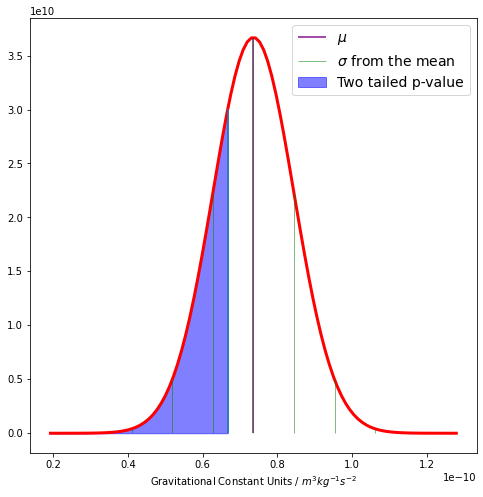

In [25]:
# ///////////////////////////
#TWO TAILED P-VALUE       //
#///////////////////////////

# Now, calculate weighted average of g measured.
print("\\\\\\\\\\\\\\\\\\\\")
# print(G, G_sigma)
weights = np.sum(1 / G_sigma) # ∑w scalar
G_waverage = (1/weights)*np.sum(G / G_sigma) #scalar
G_waverage_STDDEV = np.sqrt(1/np.sum(1/(G_sigma**2))) #scalar
print('G weighted average = ',G_waverage, '±', G_waverage_STDDEV)
# Comapre measured and predicted value using Gaussian z-score.
Zscore = (G_lit - G_waverage)/G_waverage_STDDEV
print('Z score = ',Zscore)
cdf = scipy.stats.norm.cdf(Zscore,0,1)
print ("CDF = ",cdf)
if cdf>0.5:
    pvalue_2t = 2*(1-cdf)
else :
    pvalue_2t=2*(cdf)
print ("two tailed p-value = ",pvalue_2t)

#///////////////////////////
#PLOTTING                 //
#///////////////////////////

fig3, ax3 = plt.subplots()
sigma_list = np.array([])
mu = G_waverage
for i in range(-5,5):
    sigma_list= np.append(sigma_list, mu+i*sigma)
 #np.mean(G) #Mean of Experimental Value
sigma = G_waverage_STDDEV #np.std(G)
x = np.linspace(mu - 5*sigma, mu + 5*sigma, 100)
y = scipy.stats.norm.pdf(x, mu, sigma) # BELL CURVE
ax3.plot(x, y, color='red', linewidth=3)
ymin, ymax = ax3.get_ylim()
# plt.axvline(G[0],color='C0')
# plt.axvline(G[1],color='C1')
# plt.axvline(G[2],color='C2')
# ax3.axvline(G_lit,color='C2')
ax3.vlines(G_lit, ymin=0, ymax=np.interp(G_lit,x,y))
ax3.vlines(mu, ymin=0, ymax=np.interp(mu,x,y), color='purple', alpha=0.7, linewidth=2, label='$\mu$')
ax3.vlines(sigma_list, ymin=0, ymax=np.interp(sigma_list,x,y), color='green', alpha=0.5, linewidth=1, label='$\sigma$ from the mean')
x_fill = np.linspace(mu - 5*sigma, G_lit, 100)
y_fill = scipy.stats.norm.pdf(x_fill,mu,sigma)
ax3.fill_between(x_fill,y_fill,0, alpha=0.5, color='blue', label='Two tailed p-value')
ax3.set_xlabel('Gravitational Constant Units / $m^3 kg^{-1} s^{-2}$')
ax3.legend(loc='best', fontsize=14)
fig3.savefig('cavendish_bellcurve.png', bbox_inches='tight')
plt.show()